<a href="https://colab.research.google.com/github/gladysadyaz/VAR/blob/main/FIX_Hybrid_LSTM__Wisman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import warnings
import itertools
import statsmodels.api as sm
import tensorflow.keras as keras
import seaborn as sns
import tensorflow as tf
import gc

from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.metrics import *
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from numpy import array

%matplotlib inline
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [26]:
pd.options.display.float_format = '{:.2f}'.format

# MODELING

# B. LONG SHORT TERM MEMORY

## Splitting & Scaling

In [2]:
file_path_actual = "/content/drive/My Drive/Colab Notebooks/wisman bali-kurs (1).xlsx"
df_actual = pd.read_excel(file_path_actual, sheet_name='Sheet1')
df_actual['Date'] = pd.to_datetime(df_actual['Date'], format='%d/%m/%Y')
df_actual.set_index('Date', inplace=True)
print(df_actual.head())

             Kurs  Wisman Bali  Hari Raya
Date                                     
2023-01-01  15592        10626          1
2023-01-02  15572        12338          1
2023-01-03  15590        12122          1
2023-01-04  15615        11957          1
2023-01-05  15610        13463          1


In [3]:
file_path = "/content/drive/My Drive/Colab Notebooks/varx_residuals.xlsx"
df = pd.read_excel(file_path, sheet_name='FIXVAR')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)
print(df.head())

             Kurs  Wisman Bali
Date                          
2023-01-02 -19.95         1700
2023-01-03   2.17         2052
2023-01-04  22.77         2008
2023-01-05  18.88         3759
2023-01-06  43.49         3592


In [4]:
steps_slicing = 90
df_final = df_actual[:-steps_slicing]
df_update = df_actual[-steps_slicing:]

In [5]:
# Select only the 'Wisman Bali' column for input and output
df_residual = df['Wisman Bali']
data2 = df_residual.copy()
data2

,Wisman Bali
Date,
2023-01-02,1700
2023-01-03,2052
2023-01-04,2008
2023-01-05,3759
2023-01-06,3592
...,...
2025-01-16,-2399
2025-01-17,-1242
2025-01-18,-1792


In [6]:
scaler2 = MinMaxScaler()
scaled_data2 = scaler2.fit_transform(data2.values.reshape(-1, 1))

In [7]:
# Prepare the dataset for LSTM
def create_dataset(data, time_step=1):
    dataX, dataY = [], []
    for i in range(len(data)-time_step):
        a = data[i:(i+time_step), 0]  # Use only the first column
        dataX.append(a)
        dataY.append(data[i + time_step, 0])  # Use only the first column
    return np.array(dataX), np.array(dataY)

In [8]:
# Set the time step
time_step = 10

# Create the dataset for LSTM
X2, y2 = create_dataset(scaled_data2, time_step)

# Reshape X2 to be [samples, time steps, features] which is required for LSTM
X2 = X2.reshape(X2.shape[0], X2.shape[1], 1)

In [9]:
test_size2 = 90
train_size2 = len(X2) - test_size2
X2_train, X2_test = X2[:train_size2], X2[train_size2:]
y2_train, y2_test = y2[:train_size2], y2[train_size2:]

## Hypertuning Parameters

In [10]:
# Function to create model for LSTM
def create_model_lstm2(units1, units2, dropout_rate, learning_rate, init_scheme):
    seed_value = 54
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    model = Sequential()
    model.add(LSTM(units=units1, return_sequences=True, input_shape=(time_step, 1), kernel_initializer=init_scheme))
    model.add(Dropout(rate=dropout_rate))
    model.add(LSTM(units=units2, kernel_initializer=init_scheme))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1, activation='linear', kernel_initializer=init_scheme))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [11]:
# Define the hyperparameter grid for LSTM
param_grid_lstm2 = {
    'units1': [50, 100],
    'units2': [50, 100],
    'dropout_rate': [0, 0.2, 0.3],
    'learning_rate': [0.01, 0.001],
    'batch_size': [16, 32],
    'epochs': [100],
    'init_scheme': ['glorot_uniform','he_uniform']
}

In [12]:
from itertools import product
# Convert param_grid to a list of dictionaries
param_list_lstm2 = list(product(param_grid_lstm2['units1'],
                                param_grid_lstm2['units2'],
                                param_grid_lstm2['dropout_rate'],
                                param_grid_lstm2['learning_rate'],
                                param_grid_lstm2['batch_size'],
                                param_grid_lstm2['epochs'],
                                param_grid_lstm2['init_scheme'],))

In [13]:
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import numpy as np

# Inisialisasi variabel untuk tracking model terbaik
best_score_lstm2 = float('inf')
best_params_lstm2 = None
best_model_lstm2 = None

# Ukuran train-test dan shifting antar window
train_sz = 90
test_sz = 90
shift = 80

# Loop untuk grid search dengan parameter dari param_list_lstm2
for params in tqdm(param_list_lstm2):
    val_mape_scores = []
    units1, units2, dropout_rate, learning_rate, batch_size, epochs, init_scheme = params

    for i in range(8):
        idx_train = train_sz + shift * i
        idx_test = train_sz + test_sz + shift * i

        # Split data
        X2_train, X2_test = X2[:idx_train], X2[idx_train:idx_test]
        y2_train, y2_test = y2[:idx_train], y2[idx_train:idx_test]

        # Buat model LSTM2 dengan parameter saat ini
        model_lstm2 = create_model_lstm2(units1, units2, dropout_rate, learning_rate, init_scheme)

        # Callback early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        # Training
        model_lstm2.fit(
            X2_train, y2_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X2_test, y2_test),
            callbacks=[early_stopping],
            verbose=0
        )

        # Prediksi dan inverse transform
        y2_test_pred = model_lstm2.predict(X2_test)
        y2_test_pred_denorm = scaler2.inverse_transform(y2_test_pred).flatten()
        y2_test_denorm = scaler2.inverse_transform(y2_test.reshape(-1, 1)).flatten()

        # Hitung MAPE
        mape_score = mean_absolute_percentage_error(y2_test_denorm, y2_test_pred_denorm)
        val_mape_scores.append(mape_score)

        # Opsional: lihat MAPE per window
        # print(f"MAPE window {i+1}: {mape_score:.4f}")

    # Hitung rata-rata MAPE dari 8 window
    mape_avg = np.mean(val_mape_scores)

    # Simpan jika ini model terbaik sejauh ini
    if mape_avg < best_score_lstm2:
        best_score_lstm2 = mape_avg
        best_params_lstm2 = {
            'units1': units1,
            'units2': units2,
            'dropout_rate': dropout_rate,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'epochs': epochs,
            'init_scheme': init_scheme
        }
        best_model_lstm2 = model_lstm2

# Print hasil akhir
print(f"Best LSTM2 average MAPE: {best_score_lstm2:.4f}")
print(f"Best parameters: {best_params_lstm2}")

  0%|          | 0/96 [00:00<?, ?it/s]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


  1%|          | 1/96 [01:10<1:50:51, 70.02s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


  2%|▏         | 2/96 [02:07<1:38:02, 62.58s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


  3%|▎         | 3/96 [02:34<1:11:33, 46.17s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


  4%|▍         | 4/96 [03:22<1:12:09, 47.06s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


  5%|▌         | 5/96 [04:14<1:13:53, 48.72s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


  6%|▋         | 6/96 [05:20<1:22:01, 54.69s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


  7%|▋         | 7/96 [06:02<1:14:54, 50.50s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


  8%|▊         | 8/96 [06:51<1:13:17, 49.97s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


  9%|▉         | 9/96 [07:27<1:06:30, 45.86s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 10%|█         | 10/96 [08:01<1:00:30, 42.22s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 11%|█▏        | 11/96 [08:33<54:57, 38.79s/it]  

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step


 12%|█▎        | 12/96 [09:05<51:29, 36.78s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 14%|█▎        | 13/96 [09:50<54:18, 39.25s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 15%|█▍        | 14/96 [10:24<51:30, 37.69s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 16%|█▌        | 15/96 [10:57<49:05, 36.36s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 17%|█▋        | 16/96 [11:27<45:50, 34.38s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 18%|█▊        | 17/96 [11:58<44:04, 33.48s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 19%|█▉        | 18/96 [12:36<45:05, 34.68s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 20%|█▉        | 19/96 [13:03<41:50, 32.60s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 21%|██        | 20/96 [13:37<41:45, 32.96s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 22%|██▏       | 21/96 [14:13<42:12, 33.77s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 23%|██▎       | 22/96 [14:45<41:11, 33.39s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 24%|██▍       | 23/96 [15:16<39:33, 32.51s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 25%|██▌       | 24/96 [15:44<37:34, 31.31s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 26%|██▌       | 25/96 [16:59<52:24, 44.29s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 27%|██▋       | 26/96 [17:58<56:47, 48.67s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 28%|██▊       | 27/96 [18:37<52:45, 45.87s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 29%|██▉       | 28/96 [19:14<48:58, 43.22s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 30%|███       | 29/96 [20:13<53:35, 47.99s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 31%|███▏      | 30/96 [21:02<53:04, 48.25s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 32%|███▏      | 31/96 [21:45<50:32, 46.65s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 33%|███▎      | 32/96 [22:40<52:31, 49.24s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 34%|███▍      | 33/96 [23:16<47:17, 45.04s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 35%|███▌      | 34/96 [23:55<44:53, 43.44s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 36%|███▋      | 35/96 [24:26<40:16, 39.61s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 38%|███▊      | 36/96 [24:56<36:38, 36.65s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 39%|███▊      | 37/96 [25:32<35:52, 36.49s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 40%|███▉      | 38/96 [26:06<34:38, 35.84s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 41%|████      | 39/96 [26:38<32:53, 34.61s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 42%|████▏     | 40/96 [27:13<32:24, 34.73s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 43%|████▎     | 41/96 [27:46<31:19, 34.18s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 44%|████▍     | 42/96 [28:19<30:36, 34.01s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 45%|████▍     | 43/96 [28:50<29:07, 32.97s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 46%|████▌     | 44/96 [29:19<27:40, 31.93s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 47%|████▋     | 45/96 [30:01<29:29, 34.70s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 48%|████▊     | 46/96 [30:41<30:15, 36.32s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 49%|████▉     | 47/96 [31:17<29:44, 36.42s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 50%|█████     | 48/96 [31:45<27:08, 33.92s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 51%|█████     | 49/96 [32:40<31:29, 40.20s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 52%|█████▏    | 50/96 [33:44<36:11, 47.21s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 53%|█████▎    | 51/96 [34:20<32:56, 43.91s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 54%|█████▍    | 52/96 [35:05<32:26, 44.24s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 55%|█████▌    | 53/96 [36:01<34:15, 47.81s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 56%|█████▋    | 54/96 [37:17<39:14, 56.05s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 57%|█████▋    | 55/96 [38:00<35:43, 52.28s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 58%|█████▊    | 56/96 [38:51<34:31, 51.79s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 59%|█████▉    | 57/96 [39:25<30:09, 46.41s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 60%|██████    | 58/96 [40:01<27:25, 43.30s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 61%|██████▏   | 59/96 [40:32<24:30, 39.74s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 62%|██████▎   | 60/96 [41:02<22:05, 36.83s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 64%|██████▎   | 61/96 [41:34<20:34, 35.27s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 65%|██████▍   | 62/96 [42:06<19:27, 34.33s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 66%|██████▌   | 63/96 [42:47<19:58, 36.31s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 67%|██████▋   | 64/96 [43:19<18:47, 35.23s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 68%|██████▊   | 65/96 [43:58<18:46, 36.33s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 69%|██████▉   | 66/96 [44:35<18:12, 36.42s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 70%|██████▉   | 67/96 [45:05<16:36, 34.37s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 71%|███████   | 68/96 [45:37<15:45, 33.78s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 72%|███████▏  | 69/96 [46:10<15:09, 33.68s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 73%|███████▎  | 70/96 [46:48<15:05, 34.84s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 74%|███████▍  | 71/96 [47:16<13:41, 32.87s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 75%|███████▌  | 72/96 [47:47<12:51, 32.14s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 76%|███████▌  | 73/96 [48:48<15:41, 40.92s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 77%|███████▋  | 74/96 [49:37<15:50, 43.20s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 78%|███████▊  | 75/96 [50:18<14:54, 42.58s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 79%|███████▉  | 76/96 [50:46<12:48, 38.42s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 80%|████████  | 77/96 [51:35<13:06, 41.38s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 81%|████████▏ | 78/96 [52:21<12:49, 42.72s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 82%|████████▏ | 79/96 [52:59<11:45, 41.49s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 83%|████████▎ | 80/96 [53:51<11:53, 44.57s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 84%|████████▍ | 81/96 [54:28<10:33, 42.23s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 85%|████████▌ | 82/96 [55:00<09:10, 39.30s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 86%|████████▋ | 83/96 [55:35<08:13, 38.00s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 88%|████████▊ | 84/96 [56:05<07:07, 35.60s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 89%|████████▊ | 85/96 [56:55<07:19, 39.91s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 90%|████████▉ | 86/96 [57:33<06:34, 39.43s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 91%|█████████ | 87/96 [58:02<05:26, 36.25s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 92%|█████████▏| 88/96 [58:33<04:36, 34.52s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 93%|█████████▎| 89/96 [59:11<04:09, 35.68s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 94%|█████████▍| 90/96 [59:45<03:31, 35.22s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 95%|█████████▍| 91/96 [1:00:17<02:50, 34.16s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 96%|█████████▌| 92/96 [1:00:48<02:12, 33.15s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 97%|█████████▋| 93/96 [1:01:22<01:40, 33.60s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 98%|█████████▊| 94/96 [1:01:54<01:06, 33.01s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 99%|█████████▉| 95/96 [1:02:23<00:31, 31.73s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|██████████| 96/96 [1:02:54<00:00, 39.32s/it]

Best LSTM2 average MAPE: 0.8184
Best parameters: {'units1': 100, 'units2': 100, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 100, 'init_scheme': 'he_uniform'}


## Model

In [14]:
best_params_lstm2

{'units1': 100,
 'units2': 100,
 'dropout_rate': 0.3,
 'learning_rate': 0.01,
 'batch_size': 16,
 'epochs': 100,
 'init_scheme': 'he_uniform'}

In [15]:
# Ambil parameter terbaik dari hasil grid search
manual_units1_lstm2 = best_params_lstm2['units1']
manual_units2_lstm2 = best_params_lstm2['units2']
manual_dropout_rate_lstm2 = best_params_lstm2['dropout_rate']
manual_learning_rate_lstm2 = best_params_lstm2['learning_rate']
manual_batch_size_lstm2 = best_params_lstm2['batch_size']
manual_epochs_lstm2 = best_params_lstm2['epochs']
manual_init_scheme_lstm2 = best_params_lstm2['init_scheme']

# Buat model dengan parameter terbaik
model_manual_lstm2 = create_model_lstm2(manual_units1_lstm2,
                                        manual_units2_lstm2,
                                        manual_dropout_rate_lstm2,
                                        manual_learning_rate_lstm2,
                                        manual_init_scheme_lstm2)

# Early stopping callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=50,
                               restore_best_weights=True)

# Latih model dengan parameter terbaik
history_manual_lstm2 = model_manual_lstm2.fit(X2_train,
                                              y2_train,
                                              batch_size=manual_batch_size_lstm2,
                                              epochs=manual_epochs_lstm2,
                                              validation_data=(X2_test, y2_test),
                                              callbacks=[early_stopping],
                                              verbose=1)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.4412 - val_loss: 0.0662
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0367 - val_loss: 0.0116
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0183 - val_loss: 0.0031
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0152 - val_loss: 0.0047
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0113 - val_loss: 0.0038
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0121 - val_loss: 0.0028
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0093 - val_loss: 0.0028
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0090 - val_loss: 0.0028
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 - val_loss: 0.0028
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0078 - val_loss: 0.0047
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - val_loss: 0.0031
Epoch 12/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

In [16]:
# Summary model
model_manual_lstm2.summary()

Model: "sequential_768"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1536 (LSTM)                │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1536 (Dropout)          │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1537 (LSTM)                │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1537 (Dropout)          │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_768 (Dense)               │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 363,905 (1.39 MB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 242,604 (947.68 KB)

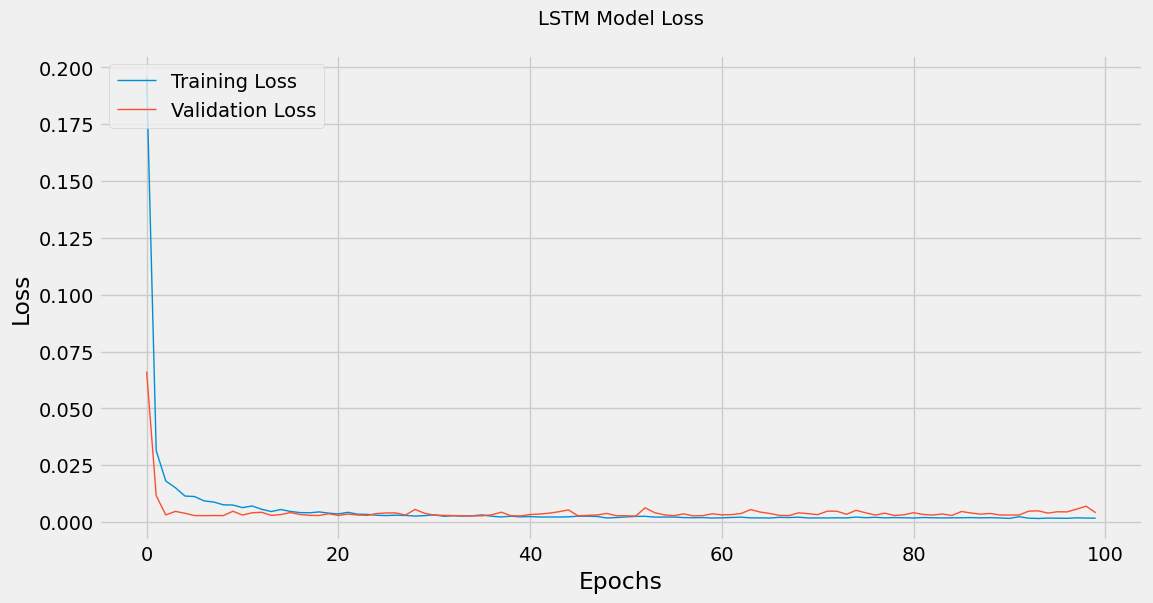

In [17]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(history_manual_lstm2.history['loss'], label='Training Loss', linewidth=1)
plt.plot(history_manual_lstm2.history['val_loss'], label='Validation Loss', linewidth=1)
plt.title('LSTM Model Loss\n', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model Loss\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [18]:
# Predict on the training data for LSTM
train_predict_lstm2 = model_manual_lstm2.predict(X2_train)
test_predict_lstm2 = model_manual_lstm2.predict(X2_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [19]:
# Inverse transform the predictions for LSTM
train_predict_lstm2 = scaler2.inverse_transform(train_predict_lstm2)
test_predict_lstm2 = scaler2.inverse_transform(test_predict_lstm2)
y2_train = scaler2.inverse_transform(y2_train.reshape(-1, 1))
y2_test = scaler2.inverse_transform(y2_test.reshape(-1, 1))

## Evaluation & Visualization

In [20]:
# Calculate MAPE for LSTM
train_mape_kurs_lstm2 = mean_absolute_percentage_error(y2_train, train_predict_lstm2)
test_mape_kurs_lstm2 = mean_absolute_percentage_error(y2_test, test_predict_lstm2)

print(f'Training MAPE (Wisman Bali) LSTM: {train_mape_kurs_lstm2:.4f}')
print(f'Testing MAPE (Wisman Bali) LSTM: {test_mape_kurs_lstm2:.4f}')


Training MAPE (Wisman Bali) LSTM: 0.4050
Testing MAPE (Wisman Bali) LSTM: 1.4036


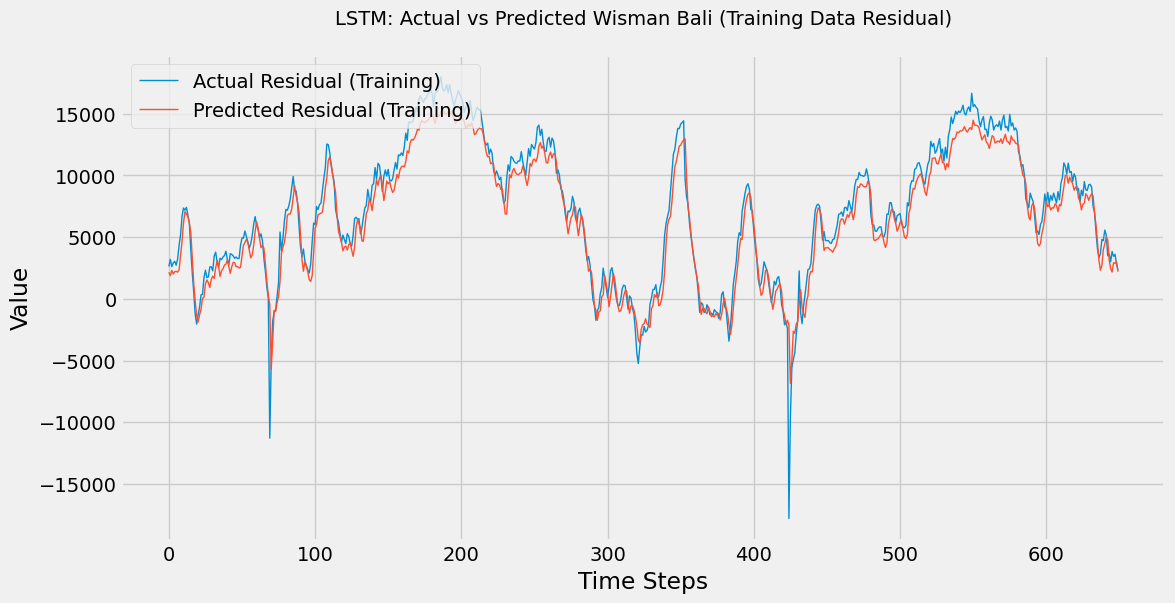

In [21]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(y2_train, label='Actual Residual (Training)', linewidth=1)
plt.plot(train_predict_lstm2, label='Predicted Residual (Training)', linewidth=1)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('LSTM: Actual vs Predicted Wisman Bali (Training Data Residual)\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

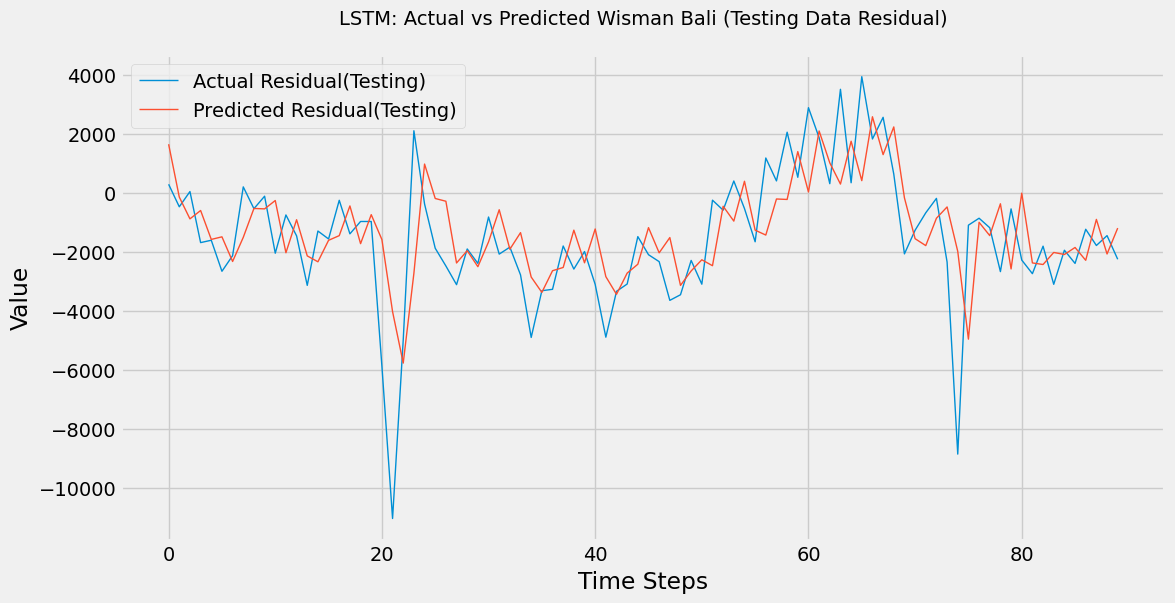

In [22]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(y2_test, label='Actual Residual(Testing)', linewidth=1)
plt.plot(test_predict_lstm2, label='Predicted Residual(Testing)', linewidth=1)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('LSTM: Actual vs Predicted Wisman Bali (Testing Data Residual)\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

## Forecasting



In [23]:
# Forecasting for the next 90 steps
predictions_lstm2 = []
input_data_lstm2 = scaled_data2[-time_step:].reshape(1, time_step, 1)

for _ in range(90):
    pred = model_manual_lstm2.predict(input_data_lstm2)
    predictions_lstm2.append(pred[0])
    input_data_lstm2 = np.append(input_data_lstm2[:, 1:, :], [[pred[0]]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

In [24]:
# Inverse transform the predictions to original scale
predictions_lstm2 = scaler2.inverse_transform(predictions_lstm2)

# Save predictions to DataFrame
df_future_predictions_lstm2 = pd.DataFrame(predictions_lstm2, columns=['Predicted Residual Wisman Bali'])

# Assuming df_update is the dataframe where you want to align future predictions, here aligning index with the valid_data's last 7 steps.
df_future_predictions_lstm2.index = df_update.index

# Display the future predictions DataFrame
df_future_predictions_lstm2

,Predicted Residual Wisman Bali
Date,
2024-10-23,-2392.249397
2024-10-24,-1994.925945
2024-10-25,-2154.571404
2024-10-26,-1916.075127
2024-10-27,-1833.606576
...,...
2025-01-16,-1768.977050
2025-01-17,-1768.977050
2025-01-18,-1768.974916


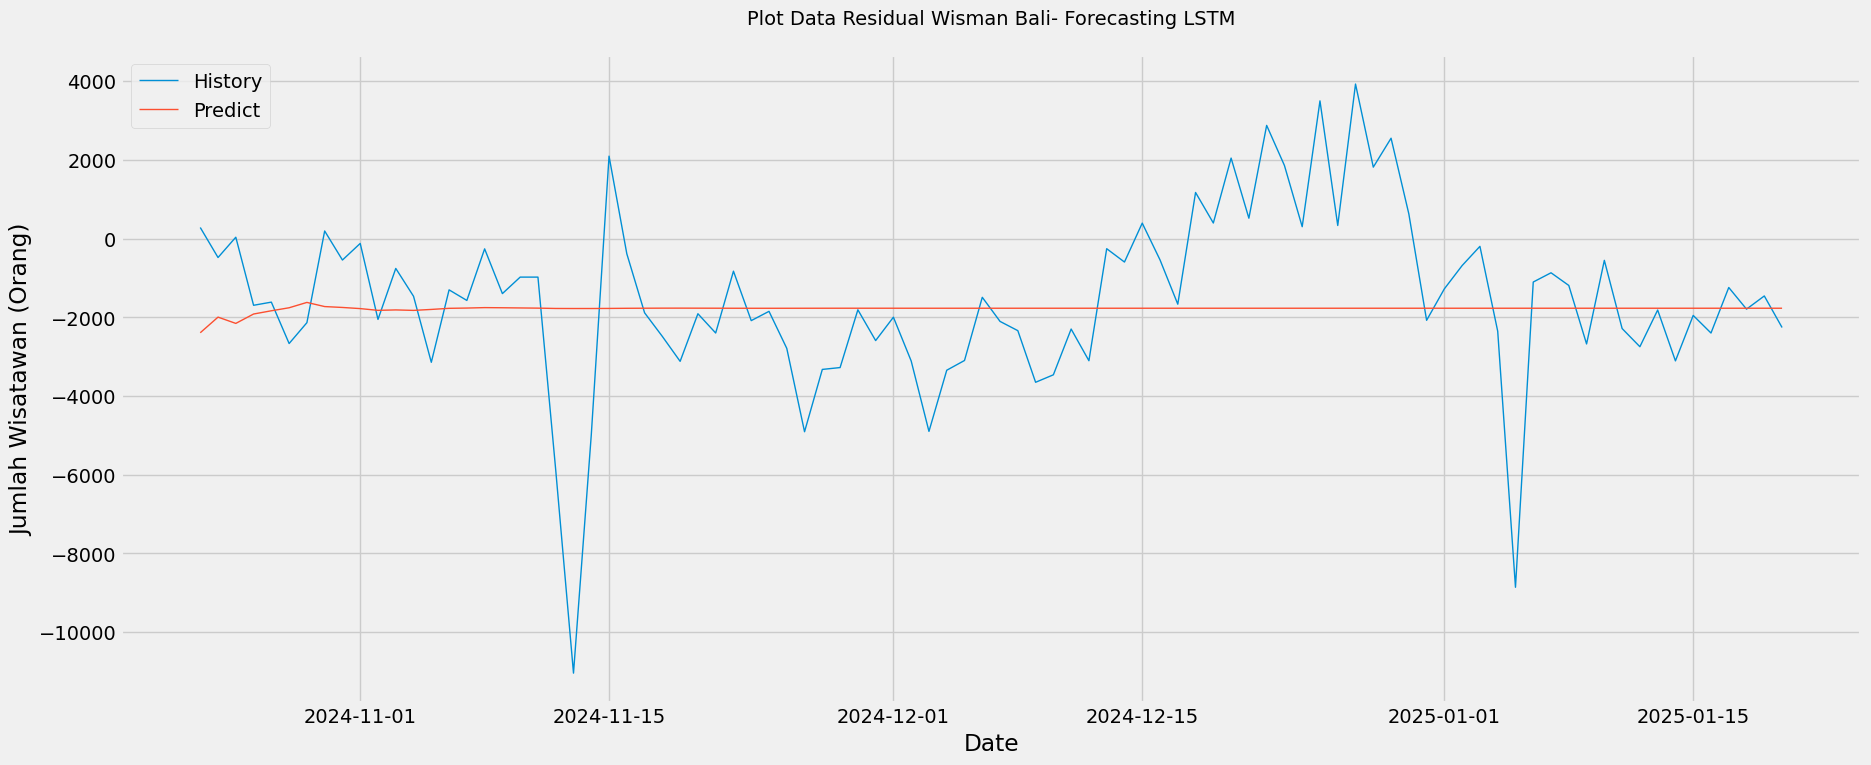

In [25]:
# Plot Data
plt.figure(figsize=(20, 8))
plt.plot(df.iloc[-90:]['Wisman Bali'], linewidth=1, label='History')
plt.plot(df_future_predictions_lstm2['Predicted Residual Wisman Bali'], linewidth=1, label='Predict')
plt.xlabel('Date')
plt.ylabel('Jumlah Wisatawan (Orang)')
plt.title('Plot Data Residual Wisman Bali- Forecasting LSTM\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# C. HYBRID VARX-LSTM

## Model

In [27]:
file_path_forecast = "/content/drive/My Drive/Colab Notebooks/varx_forecast.xlsx"
df_forecast = pd.read_excel(file_path_forecast, sheet_name='FIXVAR')
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'], format='%d/%m/%Y')
df_forecast.set_index('Date', inplace=True)
print(df_forecast.head())

               Kurs  Wisman Bali
Date                            
2024-10-23 15563.19        19031
2024-10-24 15556.90        19251
2024-10-25 15558.64        20218
2024-10-26 15557.91        19982
2024-10-27 15553.73        20022


In [28]:
df_linear = df_forecast[['Wisman Bali']]
df_linear

,Wisman Bali
Date,
2024-10-23,19031
2024-10-24,19251
2024-10-25,20218
2024-10-26,19982
2024-10-27,20022
...,...
2025-01-16,20420
2025-01-17,20432
2025-01-18,20444


In [29]:
df_nonlinear = df_future_predictions_lstm2.copy()
df_nonlinear

,Predicted Residual Wisman Bali
Date,
2024-10-23,-2392.25
2024-10-24,-1994.93
2024-10-25,-2154.57
2024-10-26,-1916.08
2024-10-27,-1833.61
...,...
2025-01-16,-1768.98
2025-01-17,-1768.98
2025-01-18,-1768.97


In [30]:
df_hybrid = pd.DataFrame({
    'Hybrid Wisman Bali': df_linear['Wisman Bali'] + df_nonlinear['Predicted Residual Wisman Bali'],
})
df_hybrid

,Hybrid Wisman Bali
Date,
2024-10-23,16638.75
2024-10-24,17256.07
2024-10-25,18063.43
2024-10-26,18065.92
2024-10-27,18188.39
...,...
2025-01-16,18651.02
2025-01-17,18663.02
2025-01-18,18675.03


In [31]:
df_hybrid_final = pd.merge(df_update['Wisman Bali'], df_hybrid, left_index=True, right_index=True)
print(df_hybrid_final.shape)
df_hybrid_final

(90, 2)


,Wisman Bali,Hybrid Wisman Bali
Date,,
2024-10-23,19314,16638.75
2024-10-24,18771,17256.07
2024-10-25,20254,18063.43
2024-10-26,18288,18065.92
2024-10-27,18408,18188.39
...,...,...
2025-01-16,18021,18651.02
2025-01-17,19190,18663.02
2025-01-18,18652,18675.03


## Evaluation & Visualization

In [32]:
# Define true and predicted 'Close' values
y_true = df_hybrid_final['Wisman Bali']
y_pred = df_hybrid_final['Hybrid Wisman Bali']

In [33]:
mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # dikali 100 agar jadi persentase
print(f"Mean Absolute Percentage Error (MAPE) for Hybrid Wisman Bali: {mape:.2f}%")

Mean Absolute Percentage Error (MAPE) for Hybrid Wisman Bali: 9.12%


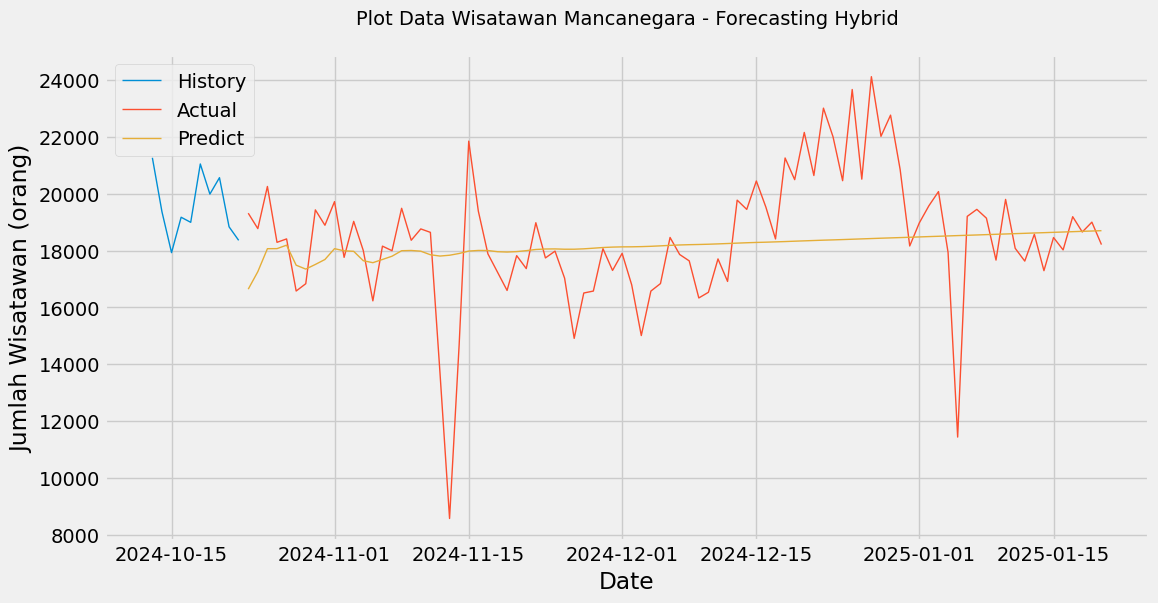

In [34]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(df_final.iloc[-10:]['Wisman Bali'], linewidth=1, label='History')
plt.plot(df_hybrid_final['Wisman Bali'], linewidth=1, label='Actual')
plt.plot(df_hybrid_final['Hybrid Wisman Bali'], linewidth=1, label='Predict')
plt.xlabel('Date')
plt.ylabel('Jumlah Wisatawan (orang)')
plt.title('Plot Data Wisatawan Mancanegara - Forecasting Hybrid\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()